# EDA

In [1]:
from datetime import datetime
import pandas_datareader.data as web
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Feature engineering

In [2]:
# Load-in the datasets for the stock
df = web.DataReader('AAPL', 'yahoo', start='2010-10-28', end='2022-10-28')

# Only save the adjusted close data and add the info on the SP 500 on the dataset
price = df[['Adj Close']]

Let's hand engineer some features. Specifically, lag and windowed features

In [3]:
# Loop over the prices 
for i in range(1, 15):
    price ['Lag {0}'.format(i)] = price['Adj Close'].shift(i)
    

/tmp/ipykernel_379/2256500.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price ['Lag {0}'.format(i)] = price['Adj Close'].shift(i)
/tmp/ipykernel_379/2256500.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price ['Lag {0}'.format(i)] = price['Adj Close'].shift(i)
/tmp/ipykernel_379/2256500.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

Check the effectiveness of the lag features.

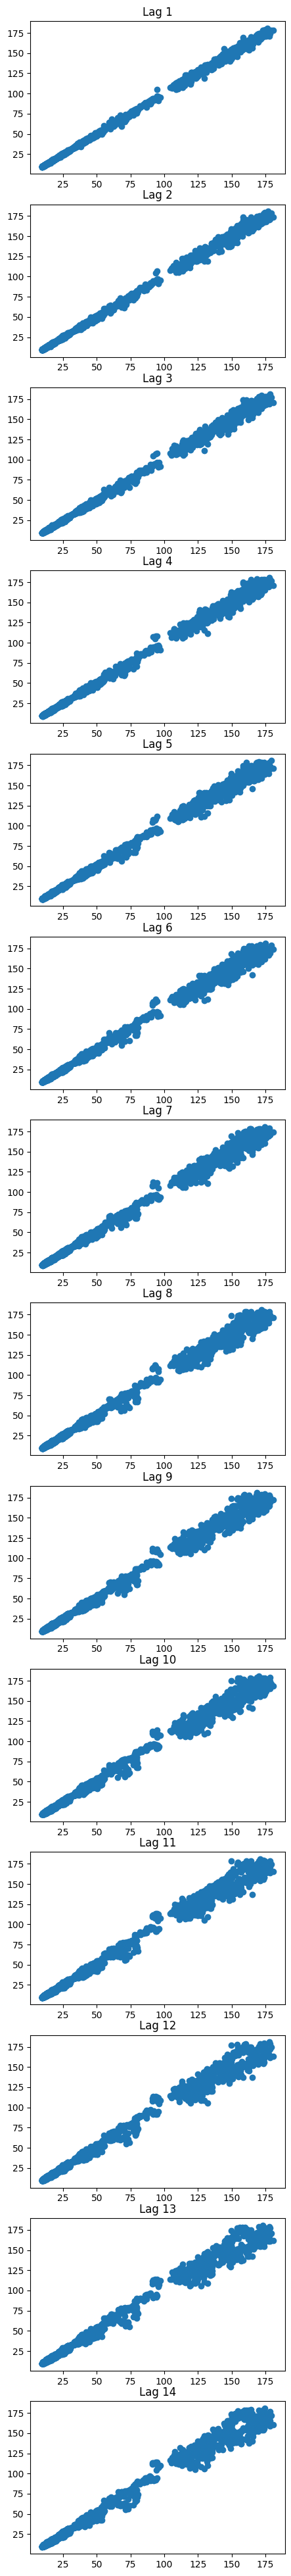

In [4]:
# Plot the relationship between the lags
fig, ax = plt.subplots(14, 1, figsize=(5, 50))

for i in range(14):
    ax[i].scatter(price['Lag {0}'.format(i + 1)], price['Adj Close'])
    ax[i].set_title('Lag {}'.format(i + 1))

plt.show()

### Data preparation

In [5]:
# Cutoff the NaN values
price = price[14:]

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Split the data train/dev/test ~ 70/30
n = len(price)
test_size = int(np.floor(n*0.3))
train = price.iloc[:(n-test_size)]
test = price.iloc[(n-test_size):]

# Declare the scaler
scaler = MinMaxScaler()

# Split feature from target
feature = price.columns[1:]
target = price.columns[0]

Xtr = train[feature]
ytr = train[target]

Xts = scaler.fit_transform(test[feature])
yts = scaler.fit_transform(np.array(test[target]).reshape(-1, 1))

### Hyperparamter tuning (Optuna)

In [7]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import optuna

# Declare the split indices
tscv = TimeSeriesSplit(n_splits=5)

# Define the objective function for it to optimize
def objective(trial):
    
    # Define the parameter for the model
    param = {
        'verbosity': 0,
        'eta': 0.01,

        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
    
        'lambda': trial.suggest_float('lambda', 1e-4, 10.0, log=True),
        'alpha' : trial.suggest_float('alpha', 1e-4, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 0.0, 10.0, step=0.1),
        
        'max_depth':trial.suggest_int("max_depth", 1, 20),
    
        'seed': 0,
        
    }
    
    # Initialize the scores list
    scores = []
    
    # Loop over the indices of the cv-split
    for train_index, dev_index in tscv.split(Xtr):
        
        # Declare the data splits
        X_train, X_dev = scaler.fit_transform(Xtr.iloc[train_index]), scaler.fit_transform(Xtr.iloc[dev_index])
        y_train, y_dev = scaler.fit_transform(np.array(ytr.iloc[train_index]).reshape(-1, 1)), scaler.fit_transform(np.array(ytr.iloc[dev_index]).reshape(-1, 1))
        
        # Feed data into Xgb dmatrix
        Dtrain = xgb.DMatrix(X_train, label=y_train)
        Ddev = xgb.DMatrix(X_dev, label=y_dev)
    
        # Train the model with the parameters above
        bst = xgb.train(param, Dtrain, num_boost_round=1000)
    
        # Predict using the model
        preds = bst.predict(Ddev)
    
        # Measure the RMSE for that iteration and append it to the scores list
        scores.append(np.sqrt(mean_squared_error(y_true=y_dev, y_pred=preds)))
        
    # Find the mean RMSE from all splits of the data
    rmse = np.mean(np.array(scores))
    
    return rmse

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)


[I 2022-11-07 09:58:12,824] A new study created in memory with name: no-name-bde0d7dc-6e5e-49fe-99af-e8c82213fb22
[W 2022-11-07 09:58:16,864] Trial 0 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/home/radia/.local/share/virtualenvs/ml_zoomcamp-Ewf7yi2T/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_379/779262592.py", line 45, in objective
    bst = xgb.train(param, Dtrain, num_boost_round=1000)
  File "/home/radia/.local/share/virtualenvs/ml_zoomcamp-Ewf7yi2T/lib/python3.10/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/home/radia/.local/share/virtualenvs/ml_zoomcamp-Ewf7yi2T/lib/python3.10/site-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/home/radia/.local/share/virtualenvs/ml_zoomcamp-Ewf7yi2T/lib/python3.10/site-packages/xgboost/core.py", line 1778, in upd

KeyboardInterrupt: 

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [11]:
# Find the best parameters
study.best_params

{'lambda': 0.0006189810211089072,
 'alpha': 0.03464670599128434,
 'gamma': 0.0,
 'max_depth': 1}

### Evaluating the model

In [10]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

# Scale the data inputs
Xtrain = scaler.fit_transform(train[feature])
ytrain = scaler.fit_transform(np.array(train[target]).reshape(-1, 1))

# Feed the test data into the Dmatrix
Dtr = xgb.DMatrix(Xtrain, label=ytrain)
Dts = xgb.DMatrix(Xts, label=yts)

# Train the model with the following hyperparameters
best_params = {
    
    'verbosity': 0,
    'eta': 0.01,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'lambda': 0.0006189810211089072,
    'alpha': 0.03464670599128434,
    'gamma': 0.0,
    'max_depth': 1,
    'seed': 0
}

In [12]:
# Train the model
best_model = xgb.train(best_params, Dtr, num_boost_round=1000)

# Evaluate the model
ypred = best_model.predict(Dts)

print("Final Results:")
print("RMSE: ", np.sqrt(mean_squared_error(y_true=yts, y_pred=ypred)))
print("MAPE: ", mean_absolute_percentage_error(y_true=yts, y_pred=ypred))
print("MAE: ", mean_absolute_error(y_true=yts, y_pred=ypred))

Final Results:
RMSE:  0.020271300579589945
MAPE:  143152869621.2816
MAE:  0.014346969623012304


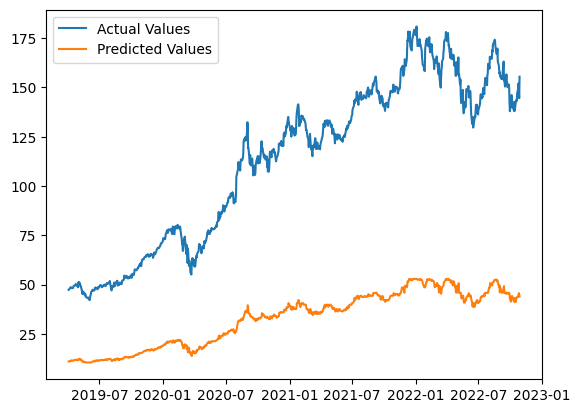

In [13]:
# Plot the predicted vs actual price
pred_price = scaler.inverse_transform(ypred.reshape(-1, 1))

plt.plot(test.index, test['Adj Close'], label='Actual Values')
plt.plot(test.index, pred_price, label='Predicted Values')

plt.legend()

plt.show()